In [1]:
import scipy as sc
import numpy as np
import pandas as pd

In [2]:
from statsmodels.stats.weightstats import *

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
data = pd.read_csv("credit_card_default_analysis.csv", sep=",", index_col=False) 
data

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,0,0,0,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,0,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


# Task 1

### Bootstrap

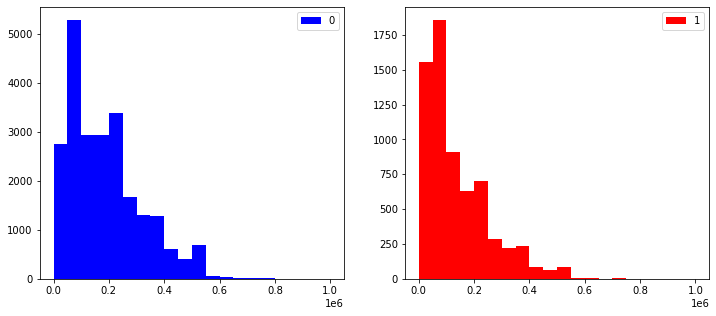

In [5]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(data[data.default == 0].LIMIT_BAL, bins = 20, color = 'b', range = (0, 1000000), label = '0')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(data[data.default == 1].LIMIT_BAL, bins = 20, color = 'r', range = (0, 1000000), label = '1')
pylab.legend()

pylab.show()

In [98]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [7]:
LIMIT_BAL0 = data[data.default == 0].LIMIT_BAL.values
LIMIT_BAL1 = data[data.default == 1].LIMIT_BAL.values

In [9]:
np.random.seed(0)

median_scores_0 = list(map(np.median, get_bootstrap_samples(LIMIT_BAL0, 5000)))
median_scores_1 = list(map(np.median, get_bootstrap_samples(LIMIT_BAL1, 5000)))

print("95% confidence interval for the 0 median repair time:",  stat_intervals(median_scores_0, 0.05))
print("95% confidence interval for the 1 median repair time:",  stat_intervals(median_scores_1, 0.05))

95% confidence interval for the 0 median repair time: [150000. 150000.]
95% confidence interval for the 1 median repair time: [80000. 90000.]


Интервальная оценка разности медиан на основе бутстрепа.

In [10]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(median_scores_0, median_scores_1)))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [-70000. -60000.]


95% доверительный интервал не содержит 0 поэтому кредитный лимит влияет на возрат кредита


b) применим перестановочный критерий для независимых выборок, чтобы проверить гипотезу о равенстве распределений

In [99]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)
def get_random_combinations(n1, n2, max_combinations):
    index = np.arange(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$ то есть LIMIT_BAL не влияет на распределение 

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$ то есть LIMIT_BAL влияет на распределение 

In [6]:
LIMIT_BAL0 = data[data.default == 0].LIMIT_BAL.values
LIMIT_BAL1 = data[data.default == 1].LIMIT_BAL.values
print ("p-value: %f" % permutation_test(LIMIT_BAL0, LIMIT_BAL1, max_permutations = 1000))

p-value: 0.001000


Нулевая гипотеза отвергается на уровне значимости 0.05, то есть  LIMIT_BAL влияет на распределение

# Task 2

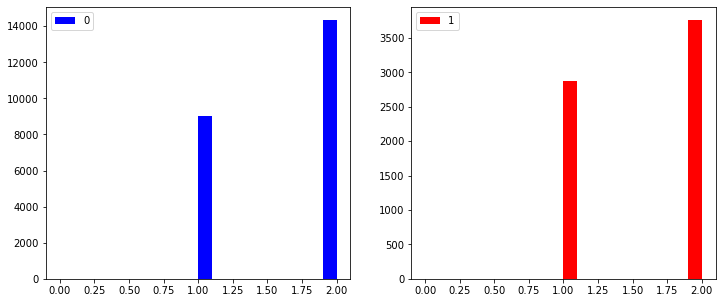

In [28]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(data[data.default == 0].SEX, bins = 20, color = 'b', range = (0, 2), label = '0')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(data[data.default == 1].SEX, bins = 20, color = 'r', range = (0, 2), label = '1')
pylab.legend()

pylab.show()

Доверительный интервал для разности долей (независимые выборки)

In [7]:
sex0 = data[data.default == 0].SEX.values
sex1 = data[data.default == 1].SEX.values

In [8]:
sex0

array([2, 2, 1, ..., 1, 1, 1], dtype=int64)

In [12]:
sex0_new=[1]*len(sex0)
sex1_new=[1]*len(sex1)
for i in range(len(sex0)):
    if sex0[i]==2:
        sex0_new[i]=0
for i in range(len(sex1)):
    if sex1[i]==2:
        sex1_new[i]=0
    

In [16]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = sc.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [17]:
print("confidence interval: [%f, %f]" % proportions_confint_diff_ind(sex1_new, sex0_new))

confidence interval: [0.033635, 0.060548]


Доверительный интервал не содержит 0, поэтому пол влияет на возрат кредита

Z-критерий для разности долей (независимые выборки)

$H_0\colon p = p{0}$ то есть пол не влияет на возврат кредита

$H_1\colon p != p{0}$ то есть пол влияет на возврат кредита

In [21]:

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - sc.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return sс.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - sc.stats.norm.cdf(z_stat)

In [24]:
proportions_diff_z_test(proportions_diff_z_stat_ind(sex1_new, sex0_new))

4.472866521609831e-12

p-value:4.472866521609831e-12

Нулевая гипотеза отвергается в пользу альтернативы:пол влияет на возврат кредита

# Task 3

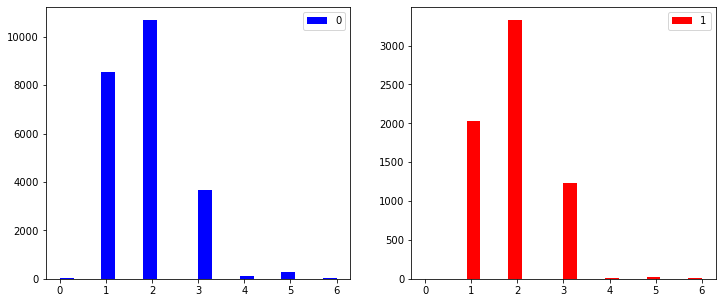

In [94]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(data[data.default == 0].EDUCATION, bins = 20, color = 'b', range = (0, 6), label = '0')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(data[data.default == 1].EDUCATION, bins = 20, color = 'r', range = (0, 6), label = '1')
pylab.legend()

pylab.show()

Критерий хи-квадрат.Критерий хи-квадрат для таблиц сопряженности может применяться при выполнении следующих условий.
Нужно, чтобы выборки были достаточно большими: n ≥ 40. Кроме того, необходимо, чтобы ожидаемое
количество элементов в каждой ячейке таблицы было меньше 5, не более, чем в 20% ячеек.


$H_0\colon$ X1 и X2 независимы 

$H_1\colon$H0 неверна 


Таблица сопряженности

In [34]:
a=data[data.default == 0].EDUCATION
b=data[data.default == 1].EDUCATION

In [35]:
a=np.array(a)
b=np.array(b)

In [36]:
a0=a1=a2=a3=a4=a5=a6=b0=b1=b2=b3=b4=b5=b6=0
for i in range(len(a)):
    if a[i]==0:
        a0+=1
    if a[i]==1:
        a1+=1
    if a[i]==2:
        a2+=1
    if a[i]==3:
        a3+=1
    if a[i]==4:
        a4+=1
    if a[i]==5:
        a5+=1
    if a[i]==6:
        a6+=1

In [40]:

for i in range(len(b)):
    if b[i]==0:
        b0+=1
    if b[i]==1:
        b1+=1
    if b[i]==2:
        b2+=1
    if b[i]==3:
        b3+=1
    if b[i]==4:
        b4+=1
    if b[i]==5:
        b5+=1
    if b[i]==6:
        b6+=1

In [51]:
contingency_table = pd.DataFrame({'0':[a0,b0],'1':[a1,b1],'2':[a2,b2],'3':[a3,b3],'4':[a4,b4],'5':[a5,b5],'6':[a6,b6]})

In [52]:
contingency_table

,0,1,2,3,4,5,6
0,14,8549,10700,3680,116,262,43
1,0,2036,3330,1237,7,18,8


In [71]:
matrix=np.array([[14.,8549.,10700.,3680.,116.,262.,43.],[1.,0.,2036.,3330.,1237.,7.,18.,8.]])

In [56]:
sc.stats.chi2_contingency(contingency_table)

(163.21655786997073,
 1.2332626245415605e-32,
 6,
 array([[1.0903200e+01, 8.2435980e+03, 1.0926564e+04, 3.8293596e+03,
         9.5792400e+01, 2.1806400e+02, 3.9718800e+01],
        [3.0968000e+00, 2.3414020e+03, 3.1034360e+03, 1.0876404e+03,
         2.7207600e+01, 6.1936000e+01, 1.1281200e+01]]))

pvalue=1.2332626245415605e-32,

нулевая гипотеза отвергается на ур.знач=0.05, то есть зависимость есть, значит образование влияет на возврат кредита

In [72]:
expected=np.array([[1.0903200e+01, 8.2435980e+03, 1.0926564e+04, 3.8293596e+03,9.5792400e+01, 2.1806400e+02, 3.9718800e+01],[3.0968000e+00, 2.3414020e+03, 3.1034360e+03, 1.0876404e+03, 2.7207600e+01, 6.1936000e+01, 1.1281200e+01]])

In [76]:
contingency_table-expected

,0,1,2,3,4,5,6
0,3.0968,305.402,-226.564,-149.3596,20.2076,43.936,3.2812
1,-3.0968,-305.402,226.564,149.3596,-20.2076,-43.936,-3.2812


в нашем случае n=30000, а ожидаемое кол-во меньше 5 только в одной ячейке. Значит, методои хи-квадрат имели право пользоваться 

Отсюда видно что магистры==1 отдают кредиты лучше всех, а бакалавры==2 хуже всех

Как нормализовать не знаю(

# Task 4

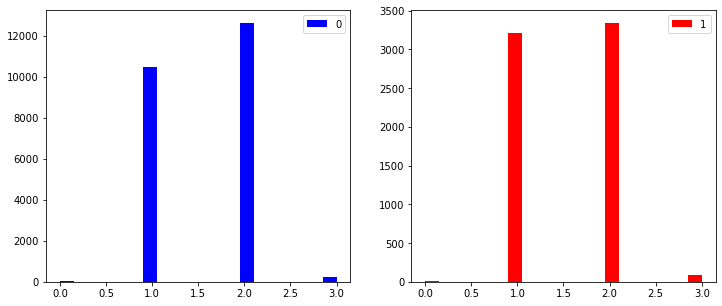

In [93]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(data[data.default == 0].MARRIAGE, bins = 20, color = 'b', range = (0, 3), label = '0')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(data[data.default == 1].MARRIAGE, bins = 20, color = 'r', range = (0, 3), label = '1')
pylab.legend()

pylab.show()

$H_0\colon$ X1 и X2 независимы 

$H_1\colon$H0 неверна 

In [78]:
a=data[data.default == 0].MARRIAGE
b=data[data.default == 1].MARRIAGE

In [79]:
a=np.array(a)
b=np.array(b)
a0=a1=a2=a3=b0=b1=b2=b3=0
for i in range(len(a)):
    if a[i]==0:
        a0+=1
    if a[i]==1:
        a1+=1
    if a[i]==2:
        a2+=1
    if a[i]==3:
        a3+=1

for i in range(len(b)):
    if b[i]==0:
        b0+=1
    if b[i]==1:
        b1+=1
    if b[i]==2:
        b2+=1
    if b[i]==3:
        b3+=1

In [80]:
table = pd.DataFrame({'0':[a0,b0],'1':[a1,b1],'2':[a2,b2],'3':[a3,b3]})

In [81]:
table

,0,1,2,3
0,49,10453,12623,239
1,5,3206,3341,84


In [82]:
sc.stats.chi2_contingency(table)

(35.66239583433609,
 8.825862457577375e-08,
 3,
 array([[4.20552000e+01, 1.06376292e+04, 1.24327632e+04, 2.51552400e+02],
        [1.19448000e+01, 3.02137080e+03, 3.53123680e+03, 7.14476000e+01]]))

In [83]:
p=8.825862457577375e-08

нулевая гипотеза отвергается на ур.знач=0.05, то есть зависимость есть

в нашем случае n=30000, а ожидаемое кол-во больше 5 во всех ячейках. Значит, методом хи-квадрат имели право пользоваться

Посчитаем коэф.Крамера.Коэффициент Крамера принимает значения исключительно в интервале от 0 до 1, то есть он не может быть
отрицательным. 0, как и раньше, соответствует полному отсутствию взаимосвязи, а 1 — полному совпадению
переменных X1 и X2 с точностью до переименования уровней. Корреляция между двумя категориальными
переменными не может быть отрицательной, поскольку уровни категориальных переменных не связаны друг
с другом отношениями порядков.

In [87]:
kr=(35.66239583433609/(30000*(2-1)))**0.5

In [88]:
kr

0.034478203662766466

коэф.Крамера мал. То есть, связь есть, но маленькая

# Task 5

# Bootstrap так же, как и в первой части

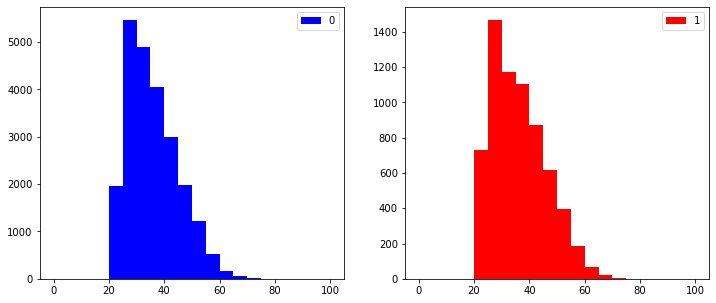

In [95]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(data[data.default == 0].AGE, bins = 20, color = 'b', range = (0, 100), label = '0')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(data[data.default == 1].AGE, bins = 20, color = 'r', range = (0, 100), label = '1')
pylab.legend()

pylab.show()

In [96]:
age0 = data[data.default == 0].AGE.values
age1 = data[data.default == 1].AGE.values

In [100]:
np.random.seed(0)

median_scores_0 = list(map(np.median, get_bootstrap_samples(age0, 5000)))
median_scores_1 = list(map(np.median, get_bootstrap_samples(age1, 5000)))

print("95% confidence interval for the 0 median repair time:",  stat_intervals(median_scores_0, 0.05))
print("95% confidence interval for the 1 median repair time:",  stat_intervals(median_scores_1, 0.05))

95% confidence interval for the 0 median repair time: [34. 34.]
95% confidence interval for the 1 median repair time: [34. 35.]


Интервальная оценка разности медиан на основе бутстрепа.

In [101]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(median_scores_0, median_scores_1)))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [0. 1.]


$H_0\colon$ разность медианных значений равна 0.

$H_1\colon$ не равно.

In [102]:
stats.ttest_1samp(delta_median_scores, 0)

Ttest_1sampResult(statistic=23.095022012221577, pvalue=3.231809712037036e-112)

 то есть разность медианных значений не равна 0, тк нулевая гипотеза отвергается

b) применим перестановочный критерий для независимых выборок, чтобы проверить гипотезу о равенстве распределений

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$ то есть возраст не влияет на распределение 

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$ то есть возраст влияет на распределение 

In [103]:

print ("p-value: %f" % permutation_test(age0, age1, max_permutations = 1000))

p-value: 0.020000


Нулевая гипотеза отвергается на уровне значимости 0.05, то есть возраст влияет на распределение